<a href="https://colab.research.google.com/github/manu675/Data_Mining_Cup_Prudsys_21/blob/master/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Cup Prudsys 2021


Task: https://www.data-mining-cup.com/dmc-2021/?utm_source=dmc&utm_medium=email&utm_campaign=newsletter

In [1]:
# importing libaries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from collections import Counter

from scipy.stats import loguniform, randint, uniform

#import imblearn
#print(imblearn.__version__)

#from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import class_weight



## Reading in the data

In [ ]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()

In [ ]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()

In [ ]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()

In [2]:
eval_df = pd.read_csv("data/evaluation.csv", sep =";")

In [3]:
items_df = pd.read_csv("data/items.csv", sep ="|")

In [4]:
transactions_df = pd.read_csv("data/transactions.csv", sep ="|")

In [5]:
eval_df.head()

,itemID
0,12
1,45274
2,10104
3,41371
4,14015


In [6]:
eval_df.shape

(1000, 1)

In [7]:
items_df.head()

,itemID,title,author,publisher,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"


In [8]:
items_df.shape

(78030, 6)

In [9]:
transactions_df.head()

,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0


In [10]:
transactions_df.shape

(365143, 5)

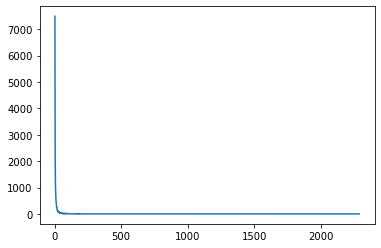

In [27]:
#Count of each item's occurrence in transactions
trans_occ = transactions_df.groupby("itemID").count().groupby("sessionID").count()['click'].to_frame()

plt.plot(trans_occ)
plt.show()

In [44]:
#COunt of each item's occurrence in tabular form
trans_occ[trans_occ['click'] > 10].sort_values('click', ascending=False)

,click
sessionID,
1,7492
2,3659
3,2157
4,1573
5,1141
...,...
81,12
76,12
86,12


In [12]:
#Count of each unique value in eval_df
eval_df['itemID'].value_counts().sort_values(ascending=False).to_frame()

,itemID
78680,1
48231,1
2054,1
18441,1
45116,1
...,...
30713,1
47098,1
71619,1
57282,1


In [13]:
#Left join transactions_df on eval_df to see how often each evaluation item occurs in transactions
#transactions_df.join(eval_df, on='itemID', how='right', lsuffix = '_trans', rsuffix = '_eval')
eval_trans_df = pd.merge(eval_df,transactions_df, on='itemID',how='left')
eval_trans_df

,itemID,sessionID,click,basket,order
0,12,NaN,NaN,NaN,NaN
1,45274,NaN,NaN,NaN,NaN
2,10104,NaN,NaN,NaN,NaN
3,41371,138327.0,1.0,0.0,0.0
4,41371,214045.0,1.0,1.0,0.0
...,...,...,...,...,...
8202,68157,270888.0,1.0,0.0,0.0
8203,44964,36017.0,1.0,0.0,0.0
8204,12971,124023.0,1.0,0.0,0.0
8205,12971,226727.0,1.0,0.0,0.0


In [42]:
#Count occurence of each evaluation item in transactions_df
#Key: ocurence = total occurence of item in session, 
#     order = total ordered units of item, 
#     basket = sum of occurences of this item in shopping basket
eval_trans_df.loc[:,'occurence'] = 1
eval_trans_df.loc[eval_trans_df['sessionID'].isnull(),'occurence'] = 0

trans_occ_df = eval_trans_df[['itemID','occurence','order','basket']].groupby(['itemID']).agg('sum')
trans_occ_df

,occurence,order,basket
itemID,,,
12,0,0.0,0.0
259,0,0.0,0.0
337,0,0.0,0.0
457,0,0.0,0.0
468,20,3.0,1.0
...,...,...,...
78486,0,0.0,0.0
78675,7,0.0,0.0
78680,0,0.0,0.0


In [15]:
#Group items by their occurence in any session: 496 out of 1000 eval items are not features in transactions_df!
trans_occ_count_df = trans_occ_df[['occurence','order']].groupby(['occurence']).count().rename(columns={'order':'items_count'})

In [41]:
trans_occ_count_df.sort_values('items_count', ascending=False)

,items_count
occurence,
0,496
1,153
2,70
3,45
4,38
6,20
5,19
7,19
8,11


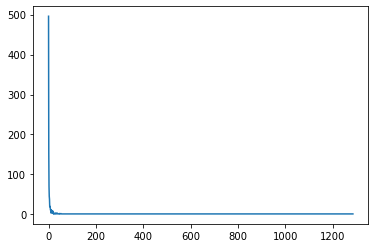

In [17]:
plt.plot(trans_occ_count_df)
plt.show()

In [18]:
#Investigation of data quality
def num_perc_NaNs(df, col_name):
    print(f"Number of NaNs in '{col_name}': {len(df[df[col_name].isna()])}")
    print(f"Percentage of NaNs in '{col_name}': {len(df[df[col_name].isna()])*100/len(df):.2f}%")
    return

num_perc_NaNs(items_df, 'title')
num_perc_NaNs(items_df, 'author')
num_perc_NaNs(items_df, 'publisher')
num_perc_NaNs(items_df, 'main topic')

Number of NaNs in 'title': 0
Percentage of NaNs in 'title': 0.00%
Number of NaNs in 'author': 3240
Percentage of NaNs in 'author': 4.15%
Number of NaNs in 'publisher': 9
Percentage of NaNs in 'publisher': 0.01%
Number of NaNs in 'main topic': 258
Percentage of NaNs in 'main topic': 0.33%


In [19]:
#List of distinct main topic values in items_df
items_df['main topic'].unique()

array(['YFB', 'AGZ', 'YFH', 'YB', 'WFTM', 'FMR', 'YBG', 'YFE', 'YZG',
       'FMB', 'YNV', 'YNWD1', 'YNVP', 'YXHL', 'YBCS', 'ATDH', 'YFHR',
       'FRD', 'YBLD', 'YBL', 'YFS', 'ATFN', 'FDB', 'FM', 'YFA', 'FBA',
       'YF', 'YFCF', 'YNVD', 'YFC', 'FYT', 'YFCB', 'YFM', 'YBGC', 'FMM',
       'JBSF1', 'JNLA', 'YZS', 'FFJ', 'YNPH', 'YNXB', 'FL', 'YXHB', 'FR',
       'DSY', 'FLS', 'YNCS', 'WZG', 'WFA', 'YNTC', 'FMT', 'FMK', 'FB',
       'WDK', 'XADC', 'FLP', 'YNNJ24', 'FLC', 'FLPB', 'YNPH2', 'FMX',
       'YFG', 'F', 'JBCT1', 'VXWT', 'FLQ', nan, 'FFK', 'YFJ', 'FKW',
       'YBCB', 'FBAN', 'FRT', 'YPCK2', 'YNNV', 'FJMS', 'YNNZ', 'YNMH',
       'FV', 'FRM', 'YXQD', 'FMH', 'YFQ', 'YNNA', 'YFCA', 'AFF', 'VXQM3',
       'XQM', 'YNNJ22', 'YPMF', 'YPCA', 'FMW', 'FHK', 'YNMC', 'FLW',
       'YBLQ', 'YBGH', 'YP', 'ATFA', 'AKLC', 'NHTZ1', 'SKR', 'FYB', 'YXJ',
       'JBSL1', 'FFH', 'WFH', 'FBC', 'CJ', 'YNG', 'YBCH', 'FKM', 'YNNB1',
       'FLR', 'YNNH4', 'YNDS', 'YNTR', 'WDHW', 'WBVS1', 'Y', 'QRSW', 

In [20]:
#Count of distinct main topic values in items_df
len(items_df['main topic'].unique())

700

In [21]:
#Count of distinct authors in items_df
len(items_df['author'].unique())

35970

In [22]:
#Cound of distinct publishers in items_df
len(items_df['publisher'].unique())

7073

In [23]:
#Cound of distinct titles in items_df
len(items_df['title'].unique())

72128

In [24]:
#Join eval_df and items_df to get more info
eval_items_df = pd.merge(eval_df,items_df, on='itemID', how='left')
eval_items_df

,itemID,title,author,publisher,main topic,subtopics
0,12,Breathtaking,Reva Ryann Thompson,Xlibris,FM,[]
1,45274,The Dead Man in Indian Creek,Mary Downing Hahn,AVON BOOKS,YFCF,"[YFZR,YXHB]"
2,10104,The Humble Seed,Linda Appleby,Linda Appleby,YFB,[YX]
3,41371,Dryadenhain & Dschinnenzauber (Märchenanthologie),"Philipp Busch, Jonathan Driedger, Lena Kalupne...",Ulisses Spiel & Medien,FM,"[FMB,WDHW]"
4,14015,The Man of Steel: Superman vs. the Moon Bandits,Scott Sonneborn,STONE ARCH BOOKS,YFCF,[XQK]
...,...,...,...,...,...,...
995,78384,Ice Cream for Breakfast,Casey Gillespie,Australian Publishing House,YFQ,[]
996,68157,Der ewige Krieg,Joe Haldeman,Heyne Taschenbuch,FLR,"[FJM,FLR,FM,FYT]"
997,44964,Back to Earth (Greek Edition): The Adventures ...,Danilo Clementoni,NaN,FM,[]
998,12971,Sharks - Read it yourself with Ladybird: Level...,Ladybird,Penguin Random House Children's UK,YNNB,[YBL]


In [25]:
#Two evaluation items have no join partner in items list
eval_items_df[eval_items_df['title'].isna()]

,itemID,title,author,publisher,main topic,subtopics
281,37378,NaN,NaN,NaN,NaN,NaN
575,47675,NaN,NaN,NaN,NaN,NaN
